<a href="https://colab.research.google.com/github/tolom131/Human-Activity-Recognition/blob/main/only_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised image denoising

## Import libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, Lambda, Normalize, Grayscale
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm.notebook import tqdm
import os
import math
import torch as tf

## Hyper parameters

In [2]:
device        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==================================================
# determine optimal hyper-parameters to obtain best testing performance
number_epoch    = 200
size_minibatch  = 128
learning_rate   = 0.1
# ==================================================

In [3]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/HAR/'
filename_data   = 'WISDM_at_v2.0_raw.txt'

import sys
sys.path.append('/content/drive/MyDrive/HAR/')
import wisdm_1_1
import wisdm_2_0
# x_train, y_train, num_classes = wisdm_1_1.create_wisdm_1_1(directory_data + filename_data)
origianl_x, original_y, num_classes = wisdm_2_0.create_wisdm_2_0(directory_data + filename_data)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


x_train.shape :  (14423, 200, 3) y_train.shape:  (14423, 6)


In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(origianl_x, original_y, random_state=42, stratify=original_y, test_size=0.2)

## Costumize dataloader for pytorch

In [5]:
class dataset (Dataset):
    def  __init__(self, data, label):

        self.data    = data
        self.label    = label
            
    def __getitem__(self, index):

        data    = self.data[index]
        label   = self.label[index]
        return (data, label)

    def __len__(self):
        return self.data.shape[0]

## Construct datasets and dataloaders for training and testing

In [6]:
## transformer를 통과하기 위해 데이터 shape 변경
x_train = x_train.reshape(-1, x_train.shape[2], x_train.shape[1])
x_test = x_test.reshape(-1, x_test.shape[2], x_test.shape[1])

dataset_train = dataset(x_train, y_train) 
dataset_test  = dataset(x_test, y_test) 

dataloader_train = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True, num_workers=2)
dataloader_test  = DataLoader(dataset_test,  batch_size=size_minibatch, shuffle=False, drop_last=True, num_workers=2) 

## Class for the neural network

In [7]:
class Classifier(nn.Module):
    def __init__(self, dim, channel, num_classes, is_alone=False):
        super(Classifier, self).__init__()
        
        if is_alone:
            self.dim = dim
            self.channel = channel
            self.num_classes = num_classes
        else:
            self.dim = dim//8
            self.channel = channel*80
            self.num_classes = num_classes

        # original inputs shape : [batch_size, channel, dim]
        # classifier inputs shape : [batch_size, channel*80, dim//8]

        self.conv1 = nn.Conv1d(self.channel, 64, kernel_size=3, padding=1, stride=1)
        self.batch1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1, stride=1)
        self.batch2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        
        self.lstm = nn.LSTM(self.dim, self.dim, batch_first=True)
        self.classifier = nn.Linear(128, self.num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs):

        x = self.conv1(inputs)
        x = self.batch1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu2(x)

        x, _ = self.lstm(x)
        x = x[:, :, -1]
        x = self.classifier(x)
        x = self.softmax(x)

        return x  

In [8]:
model = Classifier(200, 3, 6, is_alone=True)
x = torch.rand(600).view(-1, 3, 200)

c = model(x)

## model summary 용

In [9]:
# from torchsummary import summary as summary_

# model = Classifier(200, 3, 6, is_alone=True).to(device)
# summary_(model, (3, 200), batch_size=10)

## 모델링 과정을 위해 필요한 함수 정의

In [10]:
def compute_prediction(model, input):
    prediction = model(input)
    return prediction

In [11]:
def compute_mse_loss(input, prediction):
    
    mse = nn.MSELoss()
    
    # ==================================================
    # fill up the blank
    loss_mse = mse(prediction, input)
    # ==================================================
    
    loss_mse_value = loss_mse.item() 
    
    return loss_mse, loss_mse_value

In [12]:
def compute_entropy_loss(inputs, prediction):
    cross = nn.CrossEntropyLoss()

    loss_cross = cross(prediction, inputs)

    loss_cross_value = loss_cross.item()
    return loss_cross, loss_cross_value

In [13]:
def compute_accuracy(prediction, label):
    # ================================================================================ 
    # complete the function body
    b_Prediction = torch.argmax(prediction, 1)
    b_label = torch.argmax(label, 1)
    bCorrect = (b_Prediction == b_label)
    accuracy = bCorrect.float().mean() * 100
    # ================================================================================ 

    return accuracy

## 모델링 과정 정리를 위한 배열

In [14]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## Build the network

In [15]:
model = Classifier(200, 3, 6, is_alone=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
def weight_init_xavier_uniform(submodule):
    if isinstance(submodule, torch.nn.Conv1d) or isinstance(submodule, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(submodule.weight)
model.apply(weight_init_xavier_uniform)

Classifier(
  (conv1): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (lstm): LSTM(200, 200, batch_first=True)
  (classifier): Linear(in_features=128, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)

## Classifier 독립

In [17]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    loss_train_epoch        = []
    accuracy_train_epoch    = []

    model.train()

    for index_batch, (data, label) in enumerate(dataloader_train):

        data_train = data.to(device)
        label_train = label.to(device)
        
        classified = compute_prediction(model, data_train)

        # classified loss
        classified_loss, classfied_loss_value       = compute_entropy_loss(label_train, classified)

        # classified accuracy
        accuracy_train                              = compute_accuracy(classified, label_train).to("cpu")
        accuracy_train = accuracy_train.numpy()

        loss_train = classified_loss

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        loss_train_epoch.append(classfied_loss_value)
        accuracy_train_epoch.append(accuracy_train)

    loss_mean_train[i]      = np.mean(loss_train_epoch)
    loss_std_train[i]       = np.std(loss_train_epoch)

    accuracy_mean_train[i]  = np.mean(accuracy_train_epoch)
    accuracy_std_train[i]   = np.std(accuracy_train_epoch)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    loss_test_epoch        = []
    accuracy_test_epoch    = []

    with torch.no_grad():
        model.eval()

    for index_batch, (data, label) in enumerate(dataloader_test):

        data_test = data.to(device)
        label_test = label.to(device)
        
        classified             = compute_prediction(model, data_test)

        # classified loss
        classified_loss, classfied_loss_value       = compute_entropy_loss(label_test, classified)

        # classified accuracy
        accuracy_test               = compute_accuracy(classified, label_test).to("cpu")
        accuracy_test = accuracy_test.numpy()

        loss_test_epoch.append(classfied_loss_value)
        accuracy_test_epoch.append(accuracy_test)

    loss_mean_test[i]      = np.mean(loss_test_epoch)
    loss_std_test[i]       = np.std(loss_test_epoch)

    accuracy_mean_test[i]  = np.mean(accuracy_test_epoch)
    accuracy_std_test[i]   = np.std(accuracy_test_epoch)

    print(f"epoch : {i}, train acc : {np.mean(accuracy_train_epoch)}, train loss : {np.mean(loss_train_epoch)}")
    print(f"epoch : {i}, test acc : {np.mean(accuracy_test_epoch)}, test loss : {np.mean(loss_test_epoch)}")
    print()


  0%|          | 0/200 [00:00<?, ?it/s]

epoch : 0, train acc : 59.79166793823242, train loss : 1.4697224736213683
epoch : 0, test acc : 69.28266906738281, test loss : 1.351555434140292

epoch : 1, train acc : 69.921875, train loss : 1.3462997171613904
epoch : 1, test acc : 69.74431610107422, test loss : 1.3485839475284924

epoch : 2, train acc : 70.25173950195312, train loss : 1.3432315044932894
epoch : 2, test acc : 69.88636016845703, test loss : 1.3465769670226357

epoch : 3, train acc : 70.58159637451172, train loss : 1.3399890144666036
epoch : 3, test acc : 70.95170593261719, test loss : 1.3325081088326194

epoch : 4, train acc : 75.85069274902344, train loss : 1.291013851430681
epoch : 4, test acc : 76.06533813476562, test loss : 1.2848289175467058

epoch : 5, train acc : 77.109375, train loss : 1.2774167855580647
epoch : 5, test acc : 77.4147720336914, test loss : 1.2750955115665088

epoch : 6, train acc : 78.42013549804688, train loss : 1.2644982881016202
epoch : 6, test acc : 76.13636016845703, test loss : 1.28281287

## Plot 함수

In [23]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

[plot the training loss]



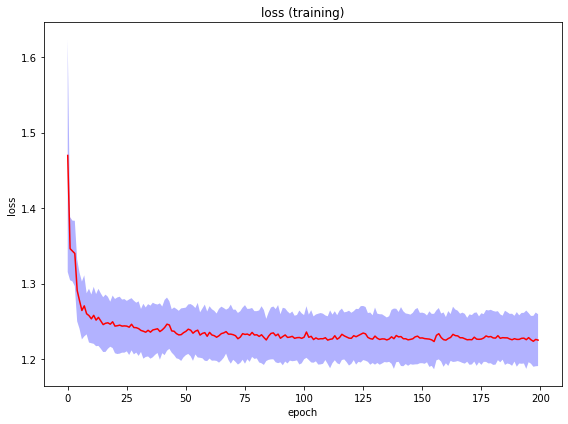

In [24]:
print('[plot the training loss]')
print('') 
plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

[plot the testing loss]



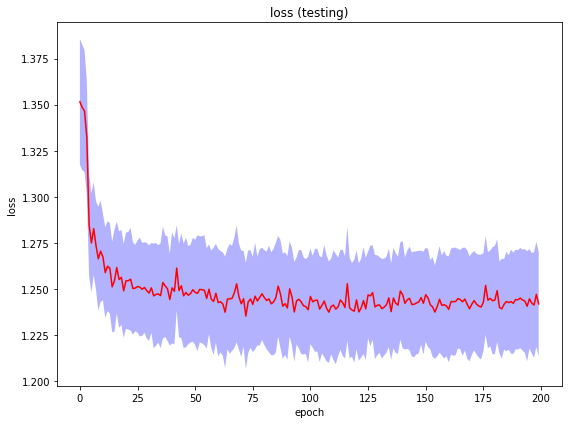

In [25]:
print('[plot the testing loss]')
print('') 
plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

[plot the traning accuracy]



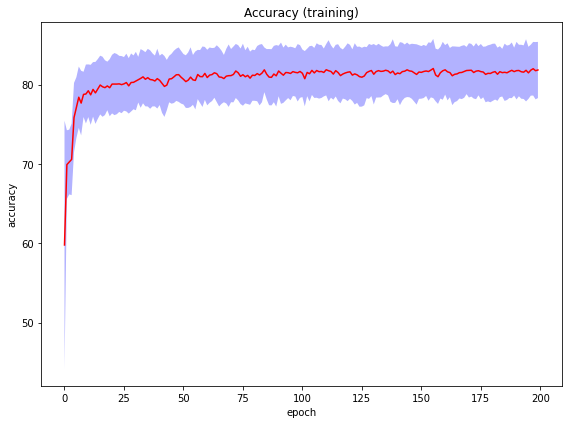

In [26]:
print('[plot the traning accuracy]') 
print('') 
plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'Accuracy (training)')

[plot the testing accuracy]



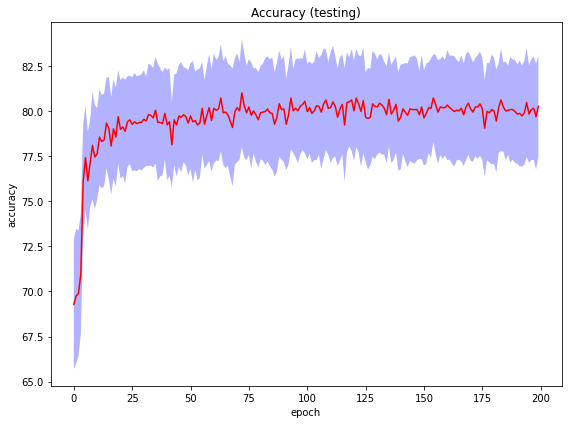

In [27]:
print('[plot the testing accuracy]') 
print('') 
plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'Accuracy (testing)')